<a href="https://colab.research.google.com/github/TheGodseeker/ML_PR/blob/main/lab4/%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Методы кластеризации и оценка качества кластеризации

Загрузите набор данных из файла cluster datasets в соответствии с вашим вариантом (если считаете, что набор данных не представляет необходимой информации или сложен для интерперетации или, то можно выбрать другой - но **необходимо предварительное согласование**).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from statistics import median, mean, stdev
from math import erfc
from sklearn.cluster import DBSCAN

df = pd.read_csv("/content/ds_salaries.csv")
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

Используйте представленные в практике методы кластеризации (помните, что кластеры строятся по классам).

Несколько правил перед выполнением задания:
0. Внимательно изучить практику 4!
1. Служебные комментарии читать внимательно и не удалять
2. Выполнить до 10-11-2023 (но не затягивать, таск не простой!)


P.S. Мгномерные данные - данные, в которых количество колонок > 3

P.S.S. Служебные комментарии - ячейки с описанием задачи в """ task description """



In [ ]:
"""
Предварительно - оптимизируйте ваш набор данных.
1. Удалить лишние колонки (порядковые признаки, с множеством пропусков, с кучей выбросов, ....)
2. Обработайте выбросы и пропуски (Для удобства - ваш коллега сделал библиотеку в pypi для анализа выбросов - подробности уточняйте в группе)
3. Скопируйте df в df_cluster # df_cluster = df.copy()
далее вы работаете с ним
4. Выполните масштабирование числовых признаков StandatdScaler || MinMaxScaler, в df_cluser замените числовые признаки на отмасштабированные
5. Для кагегориальных значений используйте LabelEncoder - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html. В df_cluster замените на encoded признаки
"""

In [ ]:

#Класс для чистки
class Burst:
  def __init__(self, df):
    self.df = df

  #Выбросы по средней
  def bursts_by_mean(self, column_name):
    mean_data = mean(self.df[column_name])
    maximum = mean_data * 2
    result = []
    col_series = self.df[column_name] # [(index, value), (index, value)]
    cur_series_size = 0

    for index, value in col_series.items():
      if abs(value) - mean_data > maximum:
        result.append(index)

    return result

  #Выбросы по критерию Шовене
  def burst_by_shovene(self, column_name):
    col_series = self.df[column_name]
    cur_series_size = 0
    result = []
    my_mean = mean(self.df[column_name])
    my_stdev = stdev(self.df[column_name])

    for index, value in col_series.items():
      if (my_stdev > 0) and erfc(abs(value-my_mean)/my_stdev) < 1 / (2*col_series.size):
          result.append(index)

    return result
  #Выбросы по квартилям
  def burst_by_quart(self, column_name):
    col_series = self.df[column_name]
    cur_series_size = 0
    result = []
    qs = col_series.quantile([0.25,0.5,0.75])

    for index, value in col_series.items():
      if (value > qs[0.75]) or (value < qs[0.25]):
        result.append(index)

    return result

  #Выбросы по двум переменным #нужно оганизовать поиск по нескольким СТОЛБЦАМ
  def burst_by_num(self, fst, scd):
    trg = self.df.loc[:, [fst, scd]].values
    # x = self.df.loc[fst]
    # y = self.df.loc[scd]

    dbscan = DBSCAN(eps = 8, min_samples = 4).fit(trg) # fitting the model
    labels = dbscan.labels_ # getting the labels

    # plt.scatter(x[:, 0], x[:,1], c = labels, cmap= "plasma") # plotting the clusters
    # plt.xlabel(fst) # X-axis label
    # plt.ylabel(scd) # Y-axis label
    # plt.show()


In [ ]:
#Убираем лишние столбцы

df = df.drop(['job_title'], axis=1)

for i in df.columns:
  if df[i].isnull().sum() > (df.size / 3):
    df = df.drop(i, axis=1)


In [ ]:
#Удаляем пустоты и выбросы
df = df.dropna()

sel_col = ['salary', 'salary_in_usd','remote_ratio']
burster = Burst(df)
for i in sel_col:
  if i in df.columns:
    df.drop(burster.burst_by_quart(i))

In [ ]:
#Копируем данные
df_cluster = df.copy()

In [ ]:
#Масштабируем

num_features = df_cluster.select_dtypes(include=['float64','int64']).columns

from sklearn.preprocessing import StandardScaler
# Standard масштабирование
scaler_std = StandardScaler()
df_cluster[num_features] = scaler_std.fit_transform(df_cluster[num_features])
# df_std_scaled.Score.unique() # преобразованные уникальные значения в числовом призанке в диапозоне [0, 1]


In [ ]:
#Манипуляции  с кат. значениями

from sklearn.preprocessing import LabelEncoder

sel_col = ['work_year', 'experience_level', 'employment_type', 'salary_currency', 'employee_residence',
       'company_location', 'company_size']

for i in sel_col:
  cur_le = LabelEncoder()
  cur_le.fit(df_cluster[i].unique())
  df_cluster[i] = cur_le.transform(df_cluster[i].values)

df_cluster

,work_year,experience_level,employment_type,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,3,3,2,-0.164827,7,-0.820391,26,1.105918,25,0
1,3,2,0,-0.239277,19,-1.706187,75,1.105918,70,2
2,3,2,0,-0.245978,19,-1.777563,75,1.105918,70,2
3,3,3,2,-0.023371,19,0.593676,11,1.105918,12,1
4,3,3,2,-0.105266,19,-0.278686,11,1.105918,12,1
...,...,...,...,...,...,...,...,...,...,...
3750,0,3,2,0.329525,19,4.352762,75,1.105918,70,0
3751,1,2,2,-0.059107,19,0.213009,75,1.105918,70,0
3752,0,0,2,-0.127602,19,-0.516603,75,1.105918,70,2
3753,0,0,0,-0.135047,19,-0.595909,75,1.105918,70,0


In [ ]:
"""
Здесь k-means и метрики. Используйте несколько вариантов метрик (из практики), для поиска оптимального числа кластеров.
"""

In [ ]:
# Создаем экземпляр модели K-Means
X = df_cluster [["experience_level", "salary_in_usd"]]

kmeans = KMeans(n_clusters=4)

# Производим кластеризацию данных
kmeans.fit(X)

# Получаем центры кластеров и прогнозируем принадлежность к кластерам
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
kmeans_2 = KMeans(n_clusters=15)

# Производим кластеризацию данных
kmeans_2.fit(X)

# Получаем центры кластеров и прогнозируем принадлежность к кластерам
cluster_centers_2 = kmeans_2.cluster_centers_
cluster_labels_2 = kmeans_2.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
"""
Здесь визуализация кластеров k-means
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

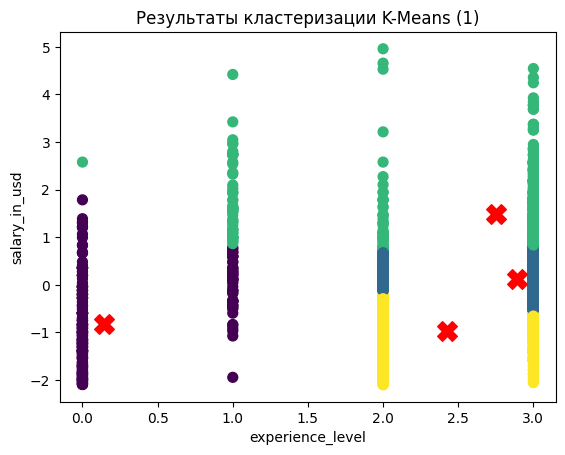

In [ ]:
# Визуализируем результаты кластеризации двумерной кластеризации
plt.scatter(df_cluster["experience_level"], df_cluster["salary_in_usd"], c=cluster_labels, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X')
plt.xlabel("experience_level")
plt.ylabel("salary_in_usd")
plt.title('Результаты кластеризации K-Means (1)')
plt.show()

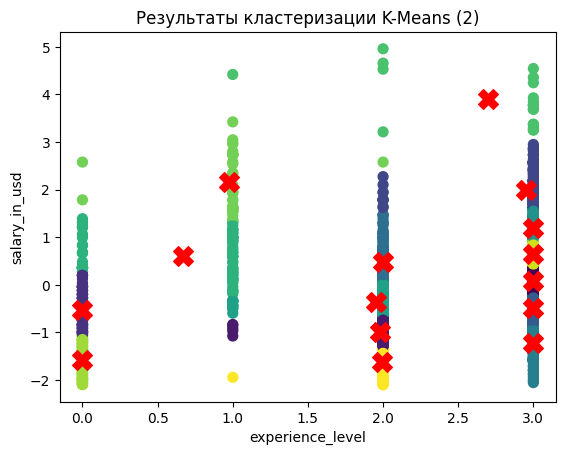

In [ ]:
# Визуализируем результаты кластеризации
plt.scatter(df_cluster["experience_level"], df_cluster["salary_in_usd"], c=cluster_labels_2, s=50, cmap='viridis')
plt.scatter(cluster_centers_2[:, 0], cluster_centers_2[:, 1], c='red', s=200, marker='X')
plt.xlabel("experience_level")
plt.ylabel("salary_in_usd")
plt.title('Результаты кластеризации K-Means (2)')
plt.show()

Оптимальное число кластеров 15, с баллом 0.5328061626115616


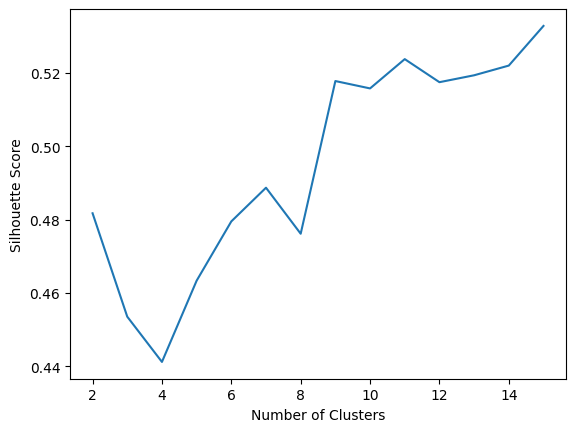

0.5328061626115616


In [ ]:
# silhouette score на 16

from sklearn.metrics import silhouette_score

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Поиск оптимального K
scores = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    scores.append(score)
print(f"Оптимальное число кластеров {scores.index(max(scores)) + 2}, с баллом {max(scores)}")
# Визуализация результатов
plt.plot(range(2, 16), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

print(score)

Оптимальное число кластеров 10, с баллом 18522.6208473723


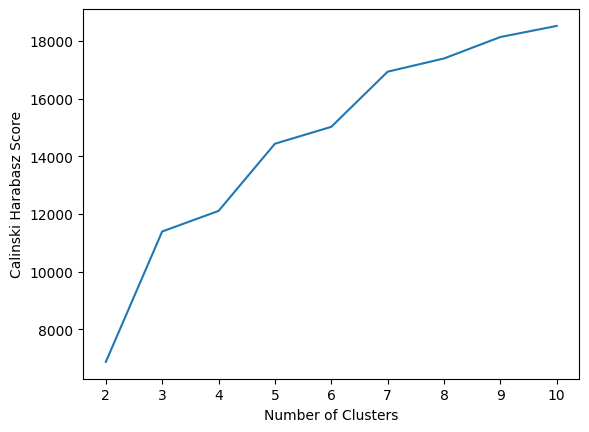

In [ ]:
#calinski_harabasz_score на 16
from sklearn.metrics import calinski_harabasz_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=16, random_state=42)
    kmeans.fit(X_scaled)
    score = calinski_harabasz_score(X_scaled, kmeans.labels_)
    scores.append(score)

print(f"Оптимальное число кластеров {scores.index(max(scores)) + 2}, с баллом {max(scores)}")

# Визуализация результатов
plt.plot(range(2, 11), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()

In [ ]:
"""
Здесь DBSCAN и метрики. Используйте поиск оптимального EPS. Объясните почему?
"""

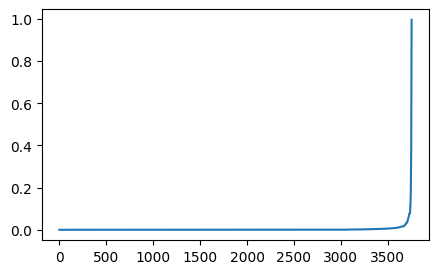

In [ ]:
#Находим eps
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(X) # fitting the data to the object
distances,indices=nbrs.kneighbors(X)

distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

Опираясь на график, можно сказать, что eps=0.035

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

x_scaler = StandardScaler().fit_transform(X)

# Инициализация и обучение модели DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples= 4)
dbscan.fit(x_scaler)

# Получение меток кластеров для каждой точки (-1 означает выбросы)
labels = dbscan.labels_

In [ ]:
"""
Здесь визуализация кластеров DBSCAN
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

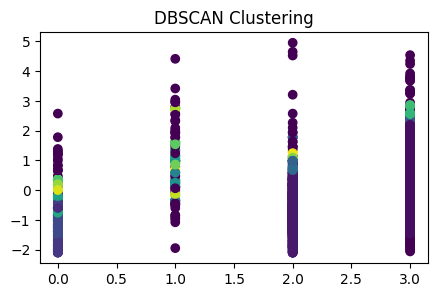

In [ ]:
# Визуализация результатов, темные точки - выбросы
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.show()

Оптимальное число кластеров 7, с баллом 0.6277497471355711


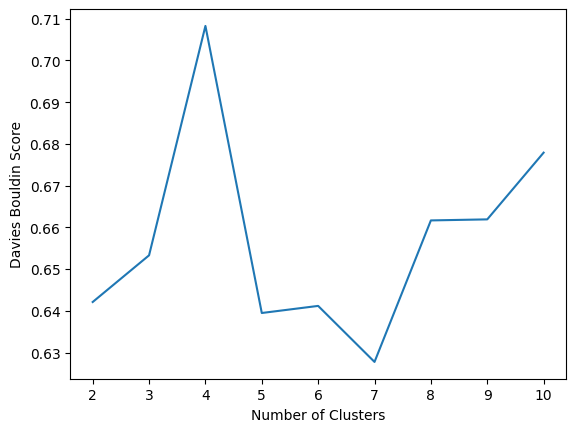

In [ ]:
from sklearn.metrics import davies_bouldin_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=16, random_state=42)
    kmeans.fit(X_scaled)
    score = davies_bouldin_score(X_scaled, kmeans.labels_)
    scores.append(score)
print(f"Оптимальное число кластеров {scores.index(min(scores)) + 2}, с баллом {min(scores)}")
# Визуализация результатов
plt.plot(range(2, 11), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.show()

In [ ]:
"""
Здесь иерархическая кластеризация и метрики
"""

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Инициализация и обучение модели иерархической кластеризации
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_clustering.fit(X)

AgglomerativeClustering(n_clusters=4)

In [ ]:
"""
Здесь визуализация кластеров иерархической кластеризации
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

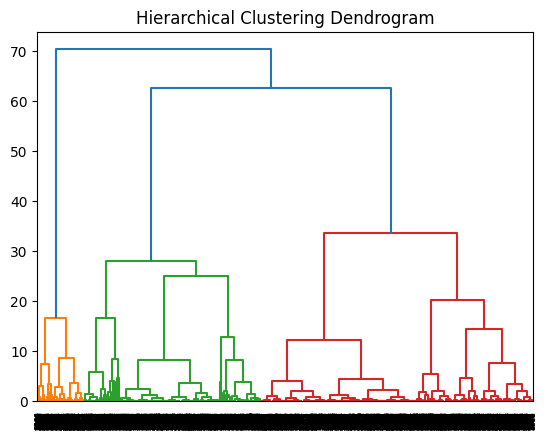

In [ ]:
# Визуализация дендрограммы
from scipy.cluster import hierarchy
linkage_matrix = hierarchy.linkage(X, method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

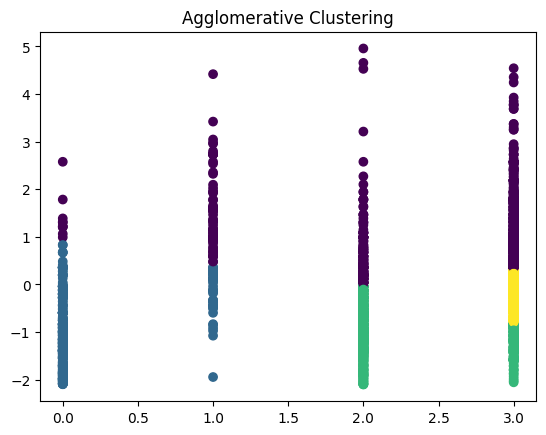

In [ ]:
# Визуализация результатов кластеризации
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=agg_clustering.labels_, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.show()

In [ ]:
!pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=36de1d018f4b90bd00a12c17427bf3aa1e7256c25bba630923f0b776798837b3
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    

Выполните профилирование набора данных относительно кластеров, используя оригинальный набор данных.

P.S. задание для всех

In [ ]:
#
#### Приветсвуется ручной анилиз - гарфики, статистика по разным кластерам, как альтернативный путь решения задачи
#

# 1. в оригинальный набор данных добавьте колонки с кластерами и работаем с ним

"""
df['kmeans_cluster'] = kmeans_cluster.labels_
df['dbsscan_cluster'] = dbsscan_cluster.labels_
...
"""

# 2. Выполните фильтрацию относительно каждого кластера и каждого алгоритма (Внимание, кластер -1 не учитываем в DBSSCAN, тк это выбросы. То есть, точки не вошли ни в одни кластер)
"""
P.S за пример взять 1 тип кластеров, выполните для всех (если кластеров больше 3, разрешено использовать первые три кластера для анализа)

from ydata_profiling import ProfileReport
df['dbscan_labels'] = dbscan.labels_

uniq_labels = tuple(set(dbscan.labels_))

print(uniq_labels)

"""

# 3. Выполните профилирование
"""
На отдельной ячейке выполните профилирование для каждого кластера и каждого алгоритма

from ydata_profiling import ProfileReport

ProfileReport(df[df.dbscan_labels == 0]) # фильтруем по кластерам из uniq_labels, получаем красивый результат :)

"""

# 4. Проанализируйте результат по кластерам. Какие переменные попали в каждый кластер, их различия (статистические), графики.
# Постарайтесь объяснить различия "фактически".
# Например, видно, что в кластер 1 у пациентов возраст выше в среднем и в медиане, чем в остальных, что может свидетельствоать о влиянии возраста на кластер №()



## Ручной анализ


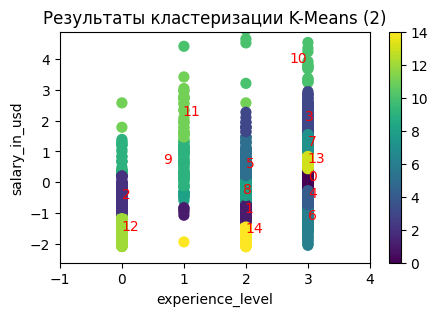

In [ ]:
plt.scatter(df_cluster["experience_level"], df_cluster["salary_in_usd"], c=cluster_labels_2, s=50, cmap='viridis')
#plt.scatter(cluster_centers_2[:, 0], cluster_centers_2[:, 1], c='red', s=200, marker='X')
plt.xlabel("experience_level")
plt.ylabel("salary_in_usd")
plt.title('Результаты кластеризации K-Means (2)')
plt.colorbar()
center_marks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# textCoord = [f"{x}" for x in centroidCoords]
x, y = np.array(cluster_centers_2).T

# for i in center_marks:
#   plt.text()

for col, row, t in zip(x, y, center_marks):
    plt.text(col, row, t, fontsize=10, color="red")
plt.xlim(min(x)-1, max(x)+1)
plt.ylim(min(y)-1, max(y)+1)

plt.show()

In [ ]:
df['kmeans_cluster'] = cluster_labels_2
cluster_centers_2

array([[ 3.00000000e+00,  6.90166501e-02],
       [ 1.97907950e+00, -9.94447848e-01],
       [-2.66453526e-15, -5.34026803e-01],
       [ 2.94871795e+00,  1.99908265e+00],
       [ 3.00000000e+00, -4.88979621e-01],
       [ 2.00000000e+00,  4.88239865e-01],
       [ 3.00000000e+00, -1.21545129e+00],
       [ 3.00000000e+00,  1.18953782e+00],
       [ 1.95522388e+00, -3.62440535e-01],
       [ 6.66666667e-01,  6.11918503e-01],
       [ 2.70000000e+00,  3.89484464e+00],
       [ 9.73684211e-01,  2.16202800e+00],
       [-3.10862447e-15, -1.57437254e+00],
       [ 3.00000000e+00,  6.47564992e-01],
       [ 1.99259259e+00, -1.61697426e+00]])

In [ ]:
#Значения по кластерам
for i in range(15):
  print("\nКластер ", i, "\n")
  print(df[df['kmeans_cluster'] == i].describe())


Кластер  0 

         work_year         salary  salary_in_usd  remote_ratio  kmeans_cluster
count   746.000000     746.000000     746.000000     746.00000           746.0
mean   2022.485255  142000.663539  141921.698391      44.63807             0.0
std       0.551189   10537.108902   10270.945275      49.54223             0.0
min    2020.000000  112700.000000  124500.000000       0.00000             0.0
25%    2022.000000  133050.000000  133225.000000       0.00000             0.0
50%    2023.000000  141525.000000  141525.000000       0.00000             0.0
75%    2023.000000  150000.000000  150000.000000     100.00000             0.0
max    2023.000000  193000.000000  160080.000000     100.00000             0.0

Кластер  1 

         work_year        salary  salary_in_usd  remote_ratio  kmeans_cluster
count   239.000000  2.390000e+02     239.000000    239.000000           239.0
mean   2022.117155  1.827804e+05   74873.209205     52.719665             1.0
std       0.790489  8.59353

In [ ]:
import seaborn as sns


<ipython-input-21-c28f41c5faf2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 0].corr()


<Axes: >

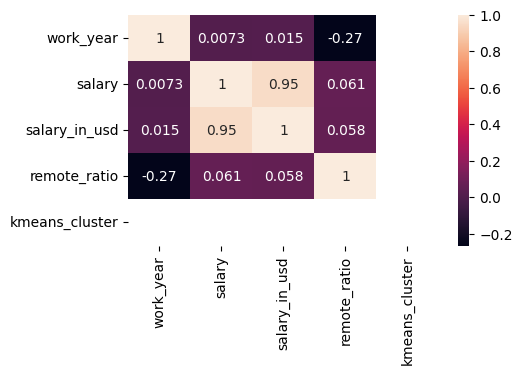

In [ ]:
#Корреляция в кластере 0
corr_matrix = df[df['kmeans_cluster'] == 0].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-24-f07ccf053762>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 1].corr()


<Axes: >

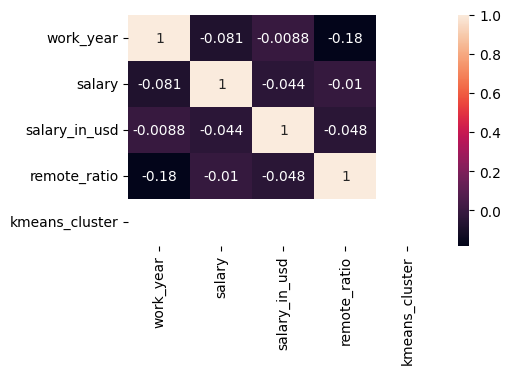

In [ ]:
#Корреляция в кластере 1
corr_matrix = df[df['kmeans_cluster'] == 1].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-25-9703d20beda8>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 2].corr()


<Axes: >

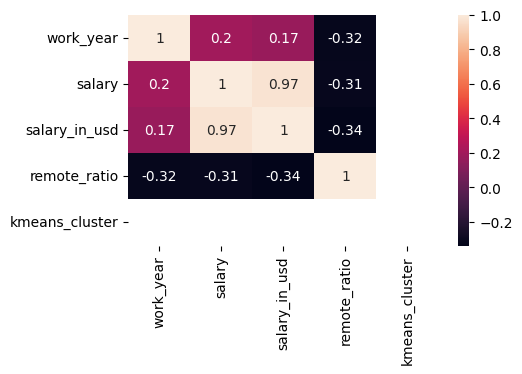

In [ ]:
#Корреляция в кластере 2
corr_matrix = df[df['kmeans_cluster'] == 2].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-26-ed18cd5ffe27>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 3].corr()


<Axes: >

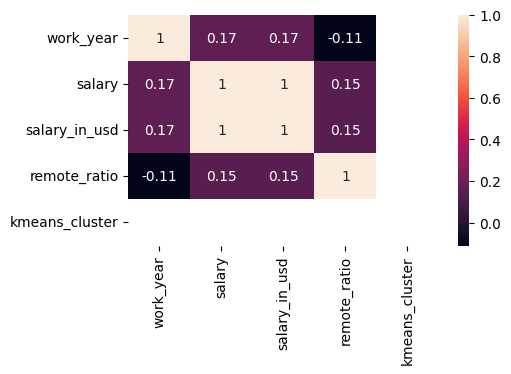

In [ ]:
#Корреляция в кластере 3
corr_matrix = df[df['kmeans_cluster'] == 3].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-27-c55647e43662>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 4].corr()


<Axes: >

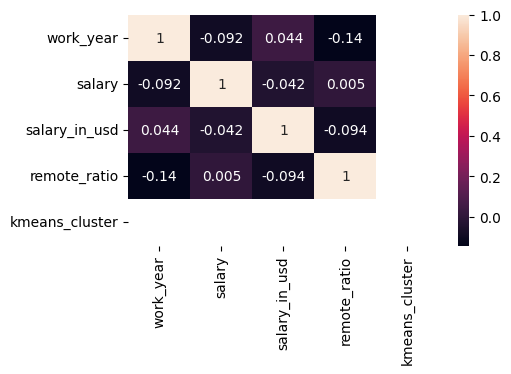

In [ ]:
#Корреляция в кластере 4
corr_matrix = df[df['kmeans_cluster'] == 4].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-28-55ceb1927ada>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 5].corr()


<Axes: >

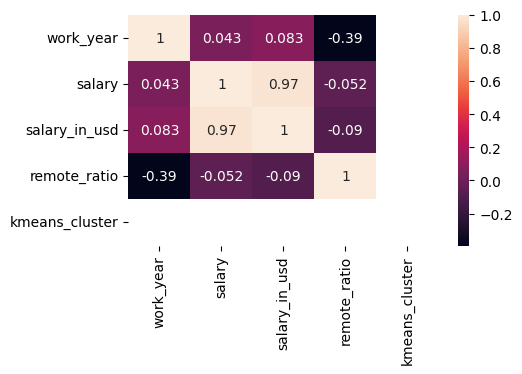

In [ ]:
#Корреляция в кластере 5
corr_matrix = df[df['kmeans_cluster'] == 5].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-29-f9ca5c5d227e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 6].corr()


<Axes: >

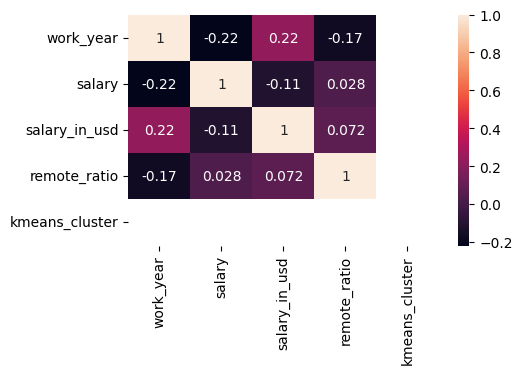

In [ ]:
#Корреляция в кластере 6
corr_matrix = df[df['kmeans_cluster'] == 6].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-31-a9ea2476012e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 8].corr()


<Axes: >

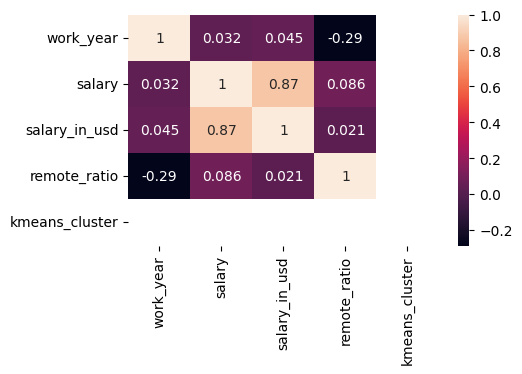

In [ ]:
#Корреляция в кластере 8
corr_matrix = df[df['kmeans_cluster'] == 8].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-32-0fe74c6f2afa>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 9].corr()


<Axes: >

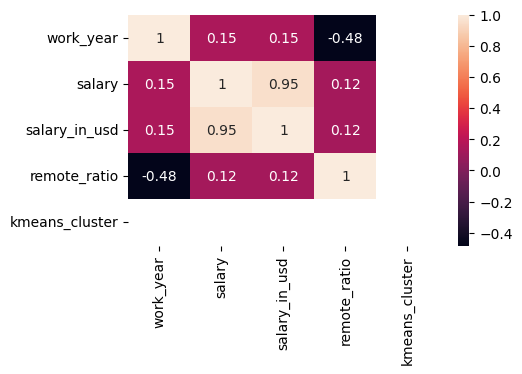

In [ ]:
#Корреляция в кластере 9
corr_matrix = df[df['kmeans_cluster'] == 9].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-33-aa670056e13e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 10].corr()


<Axes: >

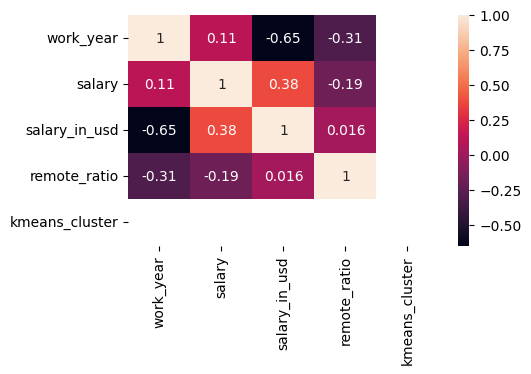

In [ ]:
#Корреляция в кластере 10
corr_matrix = df[df['kmeans_cluster'] == 10].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-34-72dce90a938d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 11].corr()


<Axes: >

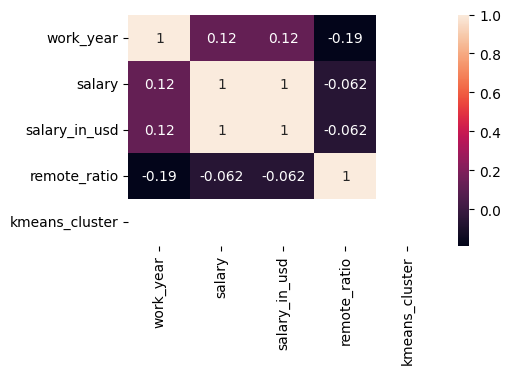

In [ ]:
#Корреляция в кластере 11
corr_matrix = df[df['kmeans_cluster'] == 11].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-35-4bf411137696>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 12].corr()


<Axes: >

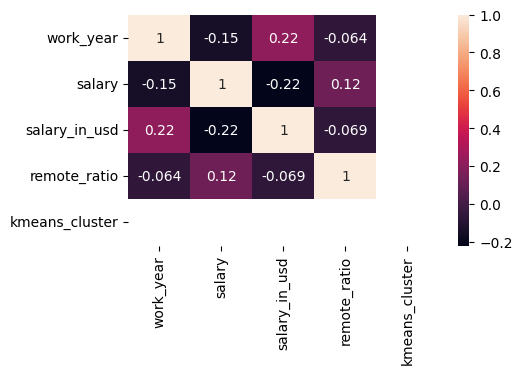

In [ ]:
#Корреляция в кластере 12
corr_matrix = df[df['kmeans_cluster'] == 12].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-36-2d009b956c28>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 13].corr()


<Axes: >

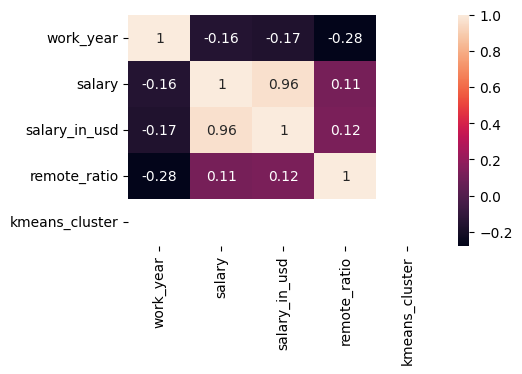

In [ ]:
#Корреляция в кластере 13
corr_matrix = df[df['kmeans_cluster'] == 13].corr()
sns.heatmap(corr_matrix, annot=True)

<ipython-input-61-729c71a56b61>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[df['kmeans_cluster'] == 14].corr()


<Axes: >

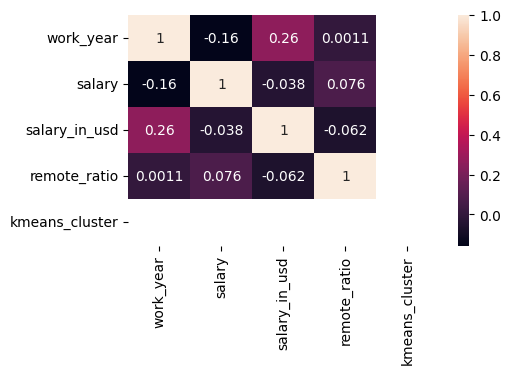

In [ ]:
#Корреляция в кластере 14
corr_matrix = df[df['kmeans_cluster'] == 14].corr()
sns.heatmap(corr_matrix, annot=True)

## Выводы

В диаграмме отношения salary_in_usd к experience_year можно выделить несколько относительно крупных кластеров: 10 (самые высокие показатели 1, 2, 3 годов работы), 11 (верхняя половина показателей 1, самые высокие показатели в 0, несколько показателей в топе 2) и 9 (верхняя треть в 0, середина 1).

Обращая внимание на их корреляцию, что 11 кластер состоит из показателей работников из США, так как корреляция между salary и salary_in_usd равна 1. 9 состоит из сотрудников Европейского союза, т.к. там используется евро, у которого малая разница в стоимости с американским долларом. В 10 собраны показания из различных компаний, о чем  свидетильствует малая, в сравнении с прошлыми показателями, корреляция.

Операясь на числовые показатели  кластеров, можно сказать, что 9 наиболее точный из тройки многочисленных, т.к. в  нем собрано больше всего показаний.

Выше описанные выводы свидетельствуют, что для тренеровки подойдут данные из 9 кластера.